# DATA

In [27]:
import numpy as np
import re
import string
import unicodedata
from unicodedata import normalize
import sys
import indicnlp
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.utils import plot_model
import numpy as np
import gensim
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec

In [2]:
def load_doc(filename):
    file = open('ENG_HIN_SMALL_DATASET.txt' , mode ='rt' , encoding = 'utf-8')
    text = file.read()
    file.close()
    return text

In [3]:
def to_pairs(text):
    lines = text.strip().split('\n') #1d list of strings
    eng_hin_pairs = [line.split('\t') for line in lines] #list
    eng_hin_pairs = np.delete(eng_hin_pairs , -1 , axis = 1)
    eng_hin_pairs = eng_hin_pairs.tolist()
    return eng_hin_pairs    

In [4]:
doc = load_doc('ENG_HIN_SMALL_DATASET.txt')
hin_eng_pairs = to_pairs(doc)
english_sentences = []
hindi_sentences = []
for i in range(len(hin_eng_pairs)):
    english_sentences.append(hin_eng_pairs[i][0])
    hindi_sentences.append(hin_eng_pairs[i][1])

In [5]:
hin_eng_pairs

[['Wow!', 'वाह!'],
 ['Help!', 'बचाओ!'],
 ['Jump.', 'उछलो.'],
 ['Jump.', 'कूदो.'],
 ['Jump.', 'छलांग.'],
 ['Hello!', 'नमस्ते।'],
 ['Hello!', 'नमस्कार।'],
 ['Cheers!', 'वाह-वाह!'],
 ['Cheers!', 'चियर्स!'],
 ['Got it?', 'समझे कि नहीं?'],
 ["I'm OK.", 'मैं ठीक हूँ।'],
 ['Awesome!', 'बहुत बढ़िया!'],
 ['Come in.', 'अंदर आ जाओ।'],
 ['Get out!', 'बाहर निकल जाओ!'],
 ['Go away!', 'चले जाओ!'],
 ['Goodbye!', 'ख़ुदा हाफ़िज़।'],
 ['Perfect!', 'उत्तम!'],
 ['Perfect!', 'सही!'],
 ['Welcome.', 'आपका स्वागत है।'],
 ['Welcome.', 'स्वागतम्।'],
 ['Have fun.', 'मज़े करना।'],
 ['Have fun.', 'मौज करना।'],
 ['Have fun.', 'मज़े करो।'],
 ['I forgot.', 'मैं भूल गया।'],
 ['I forgot.', 'मैं भूल गई।'],
 ["I'll pay.", 'मैं पैसे दूंगा।'],
 ["I'm fine.", 'मैं ठीक हूँ।'],
 ["I'm full.", 'मेरा पेट भर गया है।'],
 ["Let's go!", 'चलो चलें!'],
 ['Answer me.', 'मुझे जवाब दो।'],
 ['Birds fly.', 'पंछी उड़ते हैं।'],
 ['Excuse me.', 'माफ़ कीजिए।'],
 ['Fantastic!', 'बहुत ख़ूब!'],
 ['I fainted.', 'मैं बेहोश हो गया।'],
 ['I fear so.'

### Cleaning english data


In [6]:
def clean_english_data(lines):
    re_print = re.compile('[^%s]' %re.escape(string.printable))
    table = str.maketrans('' , '' , string.punctuation)
    clean_english_lines = []
    for line in lines:
        line = normalize('NFD' , line).encode('ascii' , 'ignore')
        line = line.decode('UTF-8')
        line = line.split()
        line = [word.lower() for word in line]
        line = [word.translate(table) for word in line]
        line = [re_print.sub('' , w) for w in line]
        line = [word for word in line if word.isalpha()]
        line = ' '.join(line)
        clean_english_lines.append(line)
    return clean_english_lines    

In [7]:
clean_english_lines = clean_english_data(english_sentences)
print(type(clean_english_lines))
print(english_sentences[0:10])
print(clean_english_lines[0:10])

<class 'list'>
['Wow!', 'Help!', 'Jump.', 'Jump.', 'Jump.', 'Hello!', 'Hello!', 'Cheers!', 'Cheers!', 'Got it?']
['wow', 'help', 'jump', 'jump', 'jump', 'hello', 'hello', 'cheers', 'cheers', 'got it']


### Clean hindi data

###### SETTING UP PATHS FOR INDIC NLP

In [8]:
INDIC_NLP_LIB_HOME=r"C:\Users\sudha\Desktop\ALL_PROJECTS\NMT_PROJECTS\Language_Translation_Chat_Bot\LSTM_MODELS\FastText_small_dataset\anoopkunchukuttan-indic_nlp_library-eccde81"
INDIC_NLP_RESOURCES=r"C:\Users\sudha\Desktop\ALL_PROJECTS\NMT_PROJECTS\Language_Translation_Chat_Bot\LSTM_MODELS\FastText_small_dataset\indic_nlp_resources-master"
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
loader.load()
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize

In [9]:
def clean_text(line):
    text = line
    text = text.replace(u',' ,'')
    text = text.replace(u'"' ,'')
    text = text.replace(u'(' ,'')
    text = text.replace(u')' ,'')
    text = text.replace(u'"' ,'')
    text = text.replace(u':' ,'')
    text = text.replace(u"'" ,'')
    text = text.replace(u"'" ,'')
    text=text.replace(u"‘‘",'')
    text=text.replace(u"’’",'')
    text=text.replace(u"''",'')
    text=text.replace(u".",'')
    text=text.replace(u"-",'')
    text=text.replace(u"।",'')
    text=text.replace(u"?",'')
    text=text.replace(u"\\",'')
    text=text.replace(u"_",'')
    text = re.sub('[a-zA-Z]' , '' , text)
    text = re.sub('[0-9+\-*/.%&!]' , '' , text)
    return text

In [10]:
def clean_hindi_data(lines):
    clean_hin_lines = []
    for line in lines:
        remove_nuktas = False
        factory = IndicNormalizerFactory()
        normalizer = factory.get_normalizer("hi" , remove_nuktas = True )
        line = clean_text(line)
        tokens = list()
        for t in indic_tokenize.trivial_tokenize(line):
            tokens.append(t)
        line = tokens
        line = [ word.lower() for word in line]
        line = [word for word in line if not re.search(r'\d', word)]
        line = ' '.join(line)
        clean_hin_lines.append(line)
    return clean_hin_lines    

In [11]:
clean_hindi_lines = clean_hindi_data(hindi_sentences)
print(hindi_sentences[133])
print(clean_hindi_lines[133])

इसे दोबारा पढ़ें।
इसे दोबारा पढ़ें


In [12]:
clean_hindi_lines

['वाह',
 'बचाओ',
 'उछलो',
 'कूदो',
 'छलांग',
 'नमस्ते',
 'नमस्कार',
 'वाहवाह',
 'चियर्स',
 'समझे कि नहीं',
 'मैं ठीक हूँ',
 'बहुत बढ़िया',
 'अंदर आ जाओ',
 'बाहर निकल जाओ',
 'चले जाओ',
 'ख़ुदा हाफ़िज़',
 'उत्तम',
 'सही',
 'आपका स्वागत है',
 'स्वागतम्',
 'मज़े करना',
 'मौज करना',
 'मज़े करो',
 'मैं भूल गया',
 'मैं भूल गई',
 'मैं पैसे दूंगा',
 'मैं ठीक हूँ',
 'मेरा पेट भर गया है',
 'चलो चलें',
 'मुझे जवाब दो',
 'पंछी उड़ते हैं',
 'माफ़ कीजिए',
 'बहुत ख़ूब',
 'मैं बेहोश हो गया',
 'खेद की बात है लेकिन वैसा ही है',
 'मैं हँसा',
 'मैं बोर हो रहा हूँ',
 'मेरा दीवालिया हो चुका है',
 'मैं थक गया हूँ',
 'ठंड हो रही है',
 'शाबाश',
 'कौन जाने',
 'किसको पता है',
 'किसे पता है',
 'किसे मालूम है',
 'अद्भुत',
 'पंछी गाते हैं',
 'अंदर आ जाओ',
 'निश्चित ही',
 'हिलो मत',
 'आग जलाती है',
 'उसका पीछा करो',
 'मुझे तैरना आता है',
 'मैं तैर सकता हूँ',
 'मैं तुमसे प्यार करती हूँ',
 'मैं तुमसे प्यार करता हूँ',
 'मैं आपसे प्यार करता हूँ',
 'मैं आपसे प्यार करती हूँ',
 'मुझे तुमसे प्यार है',
 'मैं कोशिश करूँगा',
 '

In [13]:
clean_english_lines

['wow',
 'help',
 'jump',
 'jump',
 'jump',
 'hello',
 'hello',
 'cheers',
 'cheers',
 'got it',
 'im ok',
 'awesome',
 'come in',
 'get out',
 'go away',
 'goodbye',
 'perfect',
 'perfect',
 'welcome',
 'welcome',
 'have fun',
 'have fun',
 'have fun',
 'i forgot',
 'i forgot',
 'ill pay',
 'im fine',
 'im full',
 'lets go',
 'answer me',
 'birds fly',
 'excuse me',
 'fantastic',
 'i fainted',
 'i fear so',
 'i laughed',
 'im bored',
 'im broke',
 'im tired',
 'its cold',
 'well done',
 'who knows',
 'who knows',
 'who knows',
 'who knows',
 'wonderful',
 'birds sing',
 'come on in',
 'definitely',
 'dont move',
 'fire burns',
 'follow him',
 'i can swim',
 'i can swim',
 'i love you',
 'i love you',
 'i love you',
 'i love you',
 'i love you',
 'i will try',
 'im coming',
 'im hungry',
 'im hungry',
 'let him in',
 'let him in',
 'let me out',
 'once again',
 'please sit',
 'that a boy',
 'whats new',
 'whats new',
 'whos that',
 'dont shout',
 'dont shout',
 'he stood up',
 'hes str

In [14]:
clean_eng_lines = [line.split() for line in clean_english_lines]
# sentences = [[word for word in document.split()] for document in popular_titles]

In [15]:
clean_eng_lines

[['wow'],
 ['help'],
 ['jump'],
 ['jump'],
 ['jump'],
 ['hello'],
 ['hello'],
 ['cheers'],
 ['cheers'],
 ['got', 'it'],
 ['im', 'ok'],
 ['awesome'],
 ['come', 'in'],
 ['get', 'out'],
 ['go', 'away'],
 ['goodbye'],
 ['perfect'],
 ['perfect'],
 ['welcome'],
 ['welcome'],
 ['have', 'fun'],
 ['have', 'fun'],
 ['have', 'fun'],
 ['i', 'forgot'],
 ['i', 'forgot'],
 ['ill', 'pay'],
 ['im', 'fine'],
 ['im', 'full'],
 ['lets', 'go'],
 ['answer', 'me'],
 ['birds', 'fly'],
 ['excuse', 'me'],
 ['fantastic'],
 ['i', 'fainted'],
 ['i', 'fear', 'so'],
 ['i', 'laughed'],
 ['im', 'bored'],
 ['im', 'broke'],
 ['im', 'tired'],
 ['its', 'cold'],
 ['well', 'done'],
 ['who', 'knows'],
 ['who', 'knows'],
 ['who', 'knows'],
 ['who', 'knows'],
 ['wonderful'],
 ['birds', 'sing'],
 ['come', 'on', 'in'],
 ['definitely'],
 ['dont', 'move'],
 ['fire', 'burns'],
 ['follow', 'him'],
 ['i', 'can', 'swim'],
 ['i', 'can', 'swim'],
 ['i', 'love', 'you'],
 ['i', 'love', 'you'],
 ['i', 'love', 'you'],
 ['i', 'love', 'you'],

In [16]:
clean_hin_lines = [line.split() for line in clean_hindi_lines]

In [17]:
clean_hin_lines

[['वाह'],
 ['बचाओ'],
 ['उछलो'],
 ['कूदो'],
 ['छलांग'],
 ['नमस्ते'],
 ['नमस्कार'],
 ['वाहवाह'],
 ['चियर्स'],
 ['समझे', 'कि', 'नहीं'],
 ['मैं', 'ठीक', 'हूँ'],
 ['बहुत', 'बढ़िया'],
 ['अंदर', 'आ', 'जाओ'],
 ['बाहर', 'निकल', 'जाओ'],
 ['चले', 'जाओ'],
 ['ख़ुदा', 'हाफ़िज़'],
 ['उत्तम'],
 ['सही'],
 ['आपका', 'स्वागत', 'है'],
 ['स्वागतम्'],
 ['मज़े', 'करना'],
 ['मौज', 'करना'],
 ['मज़े', 'करो'],
 ['मैं', 'भूल', 'गया'],
 ['मैं', 'भूल', 'गई'],
 ['मैं', 'पैसे', 'दूंगा'],
 ['मैं', 'ठीक', 'हूँ'],
 ['मेरा', 'पेट', 'भर', 'गया', 'है'],
 ['चलो', 'चलें'],
 ['मुझे', 'जवाब', 'दो'],
 ['पंछी', 'उड़ते', 'हैं'],
 ['माफ़', 'कीजिए'],
 ['बहुत', 'ख़ूब'],
 ['मैं', 'बेहोश', 'हो', 'गया'],
 ['खेद', 'की', 'बात', 'है', 'लेकिन', 'वैसा', 'ही', 'है'],
 ['मैं', 'हँसा'],
 ['मैं', 'बोर', 'हो', 'रहा', 'हूँ'],
 ['मेरा', 'दीवालिया', 'हो', 'चुका', 'है'],
 ['मैं', 'थक', 'गया', 'हूँ'],
 ['ठंड', 'हो', 'रही', 'है'],
 ['शाबाश'],
 ['कौन', 'जाने'],
 ['किसको', 'पता', 'है'],
 ['किसे', 'पता', 'है'],
 ['किसे', 'मालूम', 'है'],
 ['अद्भुत'],
 ['पं

### Adding SOS and EOS ,  PREPARING INPUTS FOR ENCODER AND DECODER

In [18]:
num_sentences = 2200 #(about 80-20 ratio)
input_sentences = []
output_sentences = []
output_sentences_inputs = []
#input sentences
input_sentences = clean_english_lines[0:num_sentences]

#output sentences
for line in clean_hindi_lines[0:num_sentences]:
    line = line + ' <eos>'
    output_sentences.append(line)

#output sentence input

for line in clean_hindi_lines[0:num_sentences]:
    line = '<sos> ' + line
    output_sentences_inputs.append(line)
    
len(input_sentences)
output_sentences_inputs[0:10]
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))
print(len(output_sentences + output_sentences_inputs))

num samples input: 2200
num samples output: 2200
num samples output input: 2200
4400


In [19]:
input_sentences

['wow',
 'help',
 'jump',
 'jump',
 'jump',
 'hello',
 'hello',
 'cheers',
 'cheers',
 'got it',
 'im ok',
 'awesome',
 'come in',
 'get out',
 'go away',
 'goodbye',
 'perfect',
 'perfect',
 'welcome',
 'welcome',
 'have fun',
 'have fun',
 'have fun',
 'i forgot',
 'i forgot',
 'ill pay',
 'im fine',
 'im full',
 'lets go',
 'answer me',
 'birds fly',
 'excuse me',
 'fantastic',
 'i fainted',
 'i fear so',
 'i laughed',
 'im bored',
 'im broke',
 'im tired',
 'its cold',
 'well done',
 'who knows',
 'who knows',
 'who knows',
 'who knows',
 'wonderful',
 'birds sing',
 'come on in',
 'definitely',
 'dont move',
 'fire burns',
 'follow him',
 'i can swim',
 'i can swim',
 'i love you',
 'i love you',
 'i love you',
 'i love you',
 'i love you',
 'i will try',
 'im coming',
 'im hungry',
 'im hungry',
 'let him in',
 'let him in',
 'let me out',
 'once again',
 'please sit',
 'that a boy',
 'whats new',
 'whats new',
 'whos that',
 'dont shout',
 'dont shout',
 'he stood up',
 'hes str

### creating the FastText embedding:

Let’s explore the hyperparameters used in this model.

size: Dimensionality of the word vectors. window=window_size,
min_count: The model ignores all words with total frequency lower than this.
sample: The threshold for configuring which higher-frequency words are randomly down sampled, useful range is (0, 1e-5).
workers: Use these many worker threads to train the model (=faster training with multicore machines).
sg: Training algorithm: skip-gram if sg=1, otherwise CBOW.
iter: Number of iterations (epochs) over the corpus.

In [29]:
# Defining values for parameters
embedding_size = 100
window_size = 5
min_word = 5
down_sampling = 1e-2

fast_text_model = FastText(clean_eng_lines, 
                           vector_size = embedding_size,
                           window = window_size,
                           min_count = min_word,
                           sample = down_sampling,
                           workers = 4,
                           sg = 1,
                           epochs =100)

#### save and load the FatsText model

In [30]:
fast_text_model.save("FT_model")
#load saved gensim fastext model
fast_text_model = Word2Vec.load("FT_model")

In [31]:
fast_text_model.wv['book']

array([ 0.3273489 ,  0.09398773, -0.30790126,  0.58670896,  0.32150534,
       -0.726489  ,  0.2586362 ,  0.5074875 ,  0.14622284, -0.31296384,
        0.23628941, -0.24218178,  0.06320708,  0.17579283,  0.27614582,
       -0.64200103, -0.30752552,  0.13165748, -0.6042639 , -0.8449276 ,
       -0.5752678 , -0.23289353,  0.23838633,  0.2612356 , -0.05632477,
        0.68185645,  0.17653778,  0.13929728, -0.60694706,  0.05108367,
        0.58344257, -0.5089295 , -0.16118644, -0.05287493,  0.05564289,
        0.03120311,  0.17710923, -0.22708769,  0.66810703,  0.85840344,
        0.9642424 , -0.10841635, -0.20349957,  0.27223513,  0.28984797,
        0.38934729, -0.10978404,  0.45859697,  0.20396666, -0.78369695,
        0.20769213, -0.16058698,  0.01561776, -0.7278683 , -0.21396483,
        0.24101038, -0.44950342, -0.844862  ,  0.35737342,  0.0250821 ,
       -0.91200864, -0.41043222,  0.79505193,  0.21177898,  0.61394846,
        1.5929185 ,  0.79840356,  0.23264788, -0.28896108, -0.56

In [35]:
# vocab = list(w2v_model.wv.index_to_key)
wv = fast_text_model.wv
vocab = list(fast_text_model.wv.index_to_key)
keys = fast_text_model.wv.key_to_index

In [34]:
vocab

['the',
 'i',
 'to',
 'you',
 'is',
 'a',
 'he',
 'of',
 'in',
 'it',
 'my',
 'this',
 'me',
 'have',
 'she',
 'was',
 'for',
 'are',
 'do',
 'that',
 'his',
 'your',
 'will',
 'what',
 'we',
 'on',
 'dont',
 'at',
 'him',
 'her',
 'not',
 'like',
 'with',
 'go',
 'be',
 'how',
 'and',
 'can',
 'im',
 'there',
 'has',
 'time',
 'all',
 'know',
 'up',
 'they',
 'come',
 'very',
 'as',
 'please',
 'had',
 'from',
 'its',
 'by',
 'out',
 'when',
 'want',
 'am',
 'were',
 'did',
 'here',
 'been',
 'no',
 'going',
 'cant',
 'take',
 'father',
 'an',
 'get',
 'book',
 'ill',
 'about',
 'if',
 'one',
 'money',
 'would',
 'india',
 'long',
 'tom',
 'but',
 'where',
 'today',
 'two',
 'day',
 'tomorrow',
 'us',
 'live',
 'man',
 'help',
 'must',
 'make',
 'see',
 'back',
 'our',
 'car',
 'english',
 'now',
 'home',
 'good',
 'work',
 'yesterday',
 'who',
 'these',
 'should',
 'too',
 'made',
 'many',
 'didnt',
 'so',
 'room',
 'last',
 'house',
 'well',
 'never',
 'than',
 'much',
 'off',
 'mot

In [36]:
keys

{'the': 0,
 'i': 1,
 'to': 2,
 'you': 3,
 'is': 4,
 'a': 5,
 'he': 6,
 'of': 7,
 'in': 8,
 'it': 9,
 'my': 10,
 'this': 11,
 'me': 12,
 'have': 13,
 'she': 14,
 'was': 15,
 'for': 16,
 'are': 17,
 'do': 18,
 'that': 19,
 'his': 20,
 'your': 21,
 'will': 22,
 'what': 23,
 'we': 24,
 'on': 25,
 'dont': 26,
 'at': 27,
 'him': 28,
 'her': 29,
 'not': 30,
 'like': 31,
 'with': 32,
 'go': 33,
 'be': 34,
 'how': 35,
 'and': 36,
 'can': 37,
 'im': 38,
 'there': 39,
 'has': 40,
 'time': 41,
 'all': 42,
 'know': 43,
 'up': 44,
 'they': 45,
 'come': 46,
 'very': 47,
 'as': 48,
 'please': 49,
 'had': 50,
 'from': 51,
 'its': 52,
 'by': 53,
 'out': 54,
 'when': 55,
 'want': 56,
 'am': 57,
 'were': 58,
 'did': 59,
 'here': 60,
 'been': 61,
 'no': 62,
 'going': 63,
 'cant': 64,
 'take': 65,
 'father': 66,
 'an': 67,
 'get': 68,
 'book': 69,
 'ill': 70,
 'about': 71,
 'if': 72,
 'one': 73,
 'money': 74,
 'would': 75,
 'india': 76,
 'long': 77,
 'tom': 78,
 'but': 79,
 'where': 80,
 'today': 81,
 'two'

In [49]:
fast_text_model.wv.get_vector('book')

array([ 0.3273489 ,  0.09398773, -0.30790126,  0.58670896,  0.32150534,
       -0.726489  ,  0.2586362 ,  0.5074875 ,  0.14622284, -0.31296384,
        0.23628941, -0.24218178,  0.06320708,  0.17579283,  0.27614582,
       -0.64200103, -0.30752552,  0.13165748, -0.6042639 , -0.8449276 ,
       -0.5752678 , -0.23289353,  0.23838633,  0.2612356 , -0.05632477,
        0.68185645,  0.17653778,  0.13929728, -0.60694706,  0.05108367,
        0.58344257, -0.5089295 , -0.16118644, -0.05287493,  0.05564289,
        0.03120311,  0.17710923, -0.22708769,  0.66810703,  0.85840344,
        0.9642424 , -0.10841635, -0.20349957,  0.27223513,  0.28984797,
        0.38934729, -0.10978404,  0.45859697,  0.20396666, -0.78369695,
        0.20769213, -0.16058698,  0.01561776, -0.7278683 , -0.21396483,
        0.24101038, -0.44950342, -0.844862  ,  0.35737342,  0.0250821 ,
       -0.91200864, -0.41043222,  0.79505193,  0.21177898,  0.61394846,
        1.5929185 ,  0.79840356,  0.23264788, -0.28896108, -0.56

#### Tokenizing and padding  english and hindi

In [37]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [38]:
# for vocabulary

In [39]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<sos>'] = 0
#     self.word2idx['<eos>'] = 1
    
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word


In [40]:
pairs = []
for i in range(len(input_sentences)):
    pairs.append([])
    pairs[i].append(input_sentences[i])
    pairs[i].append(output_sentences_inputs[i])
    pairs[i].append(output_sentences[i])



In [41]:
output_sentences_inputs[0:10]

['<sos> वाह',
 '<sos> बचाओ',
 '<sos> उछलो',
 '<sos> कूदो',
 '<sos> छलांग',
 '<sos> नमस्ते',
 '<sos> नमस्कार',
 '<sos> वाहवाह',
 '<sos> चियर्स',
 '<sos> समझे कि नहीं']

In [42]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(pairs):  
    inp_lang = LanguageIndex(en for en, hi,hi2 in pairs)
    targ_lang= LanguageIndex(hi for en, hi,hi2 in pairs)
#   targ_lang_decoder_output: hindi sentences with <eos>
    targ_lang = LanguageIndex(hi2 for en, hi, hi2 in pairs)
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, hi, hi2 in pairs]
    target_tensor = [[targ_lang.word2idx[s] for s in hi.split(' ')] for en, hi, hi2 in pairs]
    target_tensor_decoder_output = [[targ_lang.word2idx[s] for s in hi2.split(' ')] for en, hi, hi2 in pairs]
    max_length_inp, max_length_targ, max_length_target_decoder_output = max_length(input_tensor), max_length(target_tensor) , max_length(target_tensor_decoder_output)
    input_lang_vocab = inp_lang.vocab
    return inp_lang, targ_lang,max_length_inp, max_length_targ,max_length_target_decoder_output, input_tensor, target_tensor, target_tensor_decoder_output, input_lang_vocab




In [43]:
inp_lang, targ_lang,max_length_inp, max_length_targ,max_length_target_decoder_output, input_tensor, target_tensor, target_tensor_decoder_output, input_lang_vocab= load_dataset(pairs)
# print(targ_lang_decoder_output.word2idx)
input_lang_word2idx = inp_lang.word2idx
word2idx_outputs = targ_lang.word2idx
num_words_output = len(word2idx_outputs) + 1
input_lang_vocab = inp_lang.vocab
# input_lang_vocab
input_tensor

[[1822],
 [750],
 [851],
 [851],
 [851],
 [749],
 [749],
 [293],
 [293],
 [688, 834],
 [802, 1096],
 [128],
 [331, 808],
 [666, 1119],
 [677, 127],
 [685],
 [1153],
 [1153],
 [1752],
 [1752],
 [733, 648],
 [733, 648],
 [733, 648],
 [794, 631],
 [794, 631],
 [800, 1145],
 [802, 597],
 [802, 646],
 [910, 677],
 [75, 975],
 [189, 613],
 [540, 975],
 [567],
 [794, 559],
 [794, 581, 1448],
 [794, 892],
 [802, 205],
 [802, 225],
 [802, 1627],
 [836, 326],
 [1753, 460],
 [1771, 874],
 [1771, 874],
 [1771, 874],
 [1771, 874],
 [1801],
 [189, 1414],
 [331, 1099, 808],
 [419],
 [461, 1022],
 [602, 241],
 [616, 763],
 [794, 259, 1553],
 [794, 259, 1553],
 [794, 945, 1835],
 [794, 945, 1835],
 [794, 945, 1835],
 [794, 945, 1835],
 [794, 945, 1835],
 [794, 1780, 1669],
 [802, 334],
 [802, 788],
 [802, 788],
 [909, 763, 808],
 [909, 763, 808],
 [909, 975, 1119],
 [1100, 39],
 [1184, 1420],
 [1591, 1, 216],
 [1761, 1053],
 [1761, 1053],
 [1774, 1591],
 [461, 1396],
 [461, 1396],
 [737, 1510, 1695],
 

In [44]:
# padding

In [45]:
def padded_tensor(max_length_inp, max_length_targ, input_tensor , target_tensor, target_tensor_decoder_output):
    
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='pre')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_targ, padding='post')
    encoder_input_sequences = pad_sequences(input_tensor, maxlen=max_length_inp,padding='pre')
    decoder_input_sequences = pad_sequences(target_tensor, maxlen=max_length_targ, padding='post')
    target_tensor_decoder_output = pad_sequences(target_tensor_decoder_output, maxlen=max_length_target_decoder_output, padding='post')
    return input_tensor, target_tensor, target_tensor_decoder_output, encoder_input_sequences , decoder_input_sequences


In [46]:
input_tensor_train, target_tensor_train,target_tensor_decoder_output_train, encoder_input_sequences , decoder_input_sequences = padded_tensor(max_length_inp, max_length_targ, input_tensor , target_tensor, target_tensor_decoder_output)

In [47]:
input_tensor_train

array([[   0,    0,    0, ...,    0,    0, 1822],
       [   0,    0,    0, ...,    0,    0,  750],
       [   0,    0,    0, ...,    0,    0,  851],
       ...,
       [   0,    0, 1835, ..., 1087, 1593,  320],
       [   0, 1845,  688, ..., 1538,    1, 1606],
       [   0,    0,    0, ..., 1296,   98,  538]])

In [48]:
target_tensor_train

array([[   0, 1929,    0, ...,    0,    0,    0],
       [   0, 1394,    0, ...,    0,    0,    0],
       [   0,  183,    0, ...,    0,    0,    0],
       ...,
       [   0,  941,  449, ...,    0,    0,    0],
       [   0,  939,  823, ...,    0,    0,    0],
       [   0,  940,  153, ...,    0,    0,    0]])

### word embeddings

In [50]:
vocab = input_lang_vocab
print(len(vocab))
FT_dict = {}
for word in vocab:
    FT_dict[word] = fast_text_model.wv.get_vector(word)
    
print("the no of key-value pairs:"  , len(FT_dict))
FT_dict

1846
the no of key-value pairs: 1846


{'a': array([-2.44473547e-01, -6.66084215e-02, -9.31874216e-02,  8.18212926e-02,
        -2.65981704e-01, -1.74261376e-01,  1.17880858e-01, -1.74683779e-01,
        -2.61275116e-02,  2.13309303e-02, -3.76791954e-01, -3.52477469e-02,
        -1.79700762e-01, -1.28262401e-01,  1.00624725e-01, -2.25071758e-02,
        -1.66327700e-01, -2.30148271e-01,  3.94533426e-02,  3.12034249e-01,
         8.48107710e-02,  3.72518376e-02,  2.08253771e-01,  2.42654637e-01,
        -1.24668419e-01, -4.77942005e-02, -3.77310105e-02, -1.87536359e-01,
         1.50135338e-01,  2.08895802e-02,  2.47058287e-01, -3.12471390e-01,
        -8.83947536e-02,  1.33566171e-01,  5.78154810e-04,  2.49602869e-01,
         1.17214862e-04,  1.13148846e-01,  1.34202167e-01,  1.06314957e-01,
         3.77132706e-02, -1.71580613e-01, -1.83633238e-01, -8.43863785e-02,
        -2.55496651e-01, -2.62099132e-02, -1.70627281e-01,  2.25192517e-01,
         2.98713800e-03, -6.85291141e-02,  6.90627173e-02,  1.03384510e-01,
       

The dictionary embeddings_dictionary now contains words and corresponding GloVe embeddings for all the words.

We want the word embeddings for only those words that are present in our corpus. We will create a two dimensional numpy array of 44 (size of vocabulary) rows and 100 columns. The array will initially contain zeros. The array will be named as embedding_matrix

Next, we will iterate through each word in our corpus by traversing the word_tokenizer.word_index dictionary that contains our words and their corresponding index.

Each word will be passed as key to the embedding_dictionary to retrieve the corresponding 100 dimensional vector for the word. The 100 dimensional vector will then be stored at the corresponding index of the word in the embedding_matrix. Look at the following script:

In [51]:
num_words = min(MAX_NUM_WORDS, len(input_lang_vocab) + 1)
# embedding_matrix = zeros((len(input_lang_vocab)+1, 100))
# for word, index in input_lang_word2idx.items(): #input_lang_word2idx=1847
#     embedding_vector = embeddings_dictionary.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector
        
# creating the embedding matrix
embedding_matrix = np.zeros(shape= (len(input_lang_vocab)+1 , 100))
for word,i in input_lang_word2idx.items():
    embedding_vector = FT_dict.get(word)
    if embedding_vector is not None:   # word is in the vocabulary learned by the w2v model
        embedding_matrix[i]=embedding_vector
     # if word is not found then embed_vector corressponding to that vector will stay zero.


In [52]:
embedding_matrix.shape

(1847, 100)

In [53]:
# creating the embedding layer

In [54]:
embedding_layer = Embedding(num_words , EMBEDDING_SIZE , weights = [embedding_matrix] , input_length = max_length_inp)


In [55]:
num_words

1847

In [56]:
embedding_matrix.shape

(1847, 100)

In [57]:
max_length_inp

10

# MODEL

## CREATING THE MODEL

In [58]:
decoder_targets_one_hot = np.zeros((len(input_sentences) , max_length_targ , num_words_output), dtype = 'float32')


In [59]:
decoder_targets_one_hot.shape

(2200, 16, 2257)

In [60]:
type(decoder_targets_one_hot)

numpy.ndarray

In [61]:
for i, d in enumerate(target_tensor_decoder_output_train):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [62]:
print(decoder_targets_one_hot[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## create the encoder and decoders

In [63]:
encoder_inputs_placeholder = Input(shape = (max_length_inp,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state = True)
encoder_outputs, h ,c = encoder(x)
encoder_states = [h,c]

In [64]:
decoder_inputs_placeholder = Input(shape= (max_length_targ,))

decoder_embedding = Embedding(num_words_output , LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES , return_sequences = True , return_state = True)

decoder_outputs , _ , _ = decoder_lstm(decoder_inputs_x , initial_state = encoder_states)


In [65]:
decoder_dense= Dense(num_words_output , activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)


## compile the model:

In [66]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder] , decoder_outputs)

model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


## plotting the model

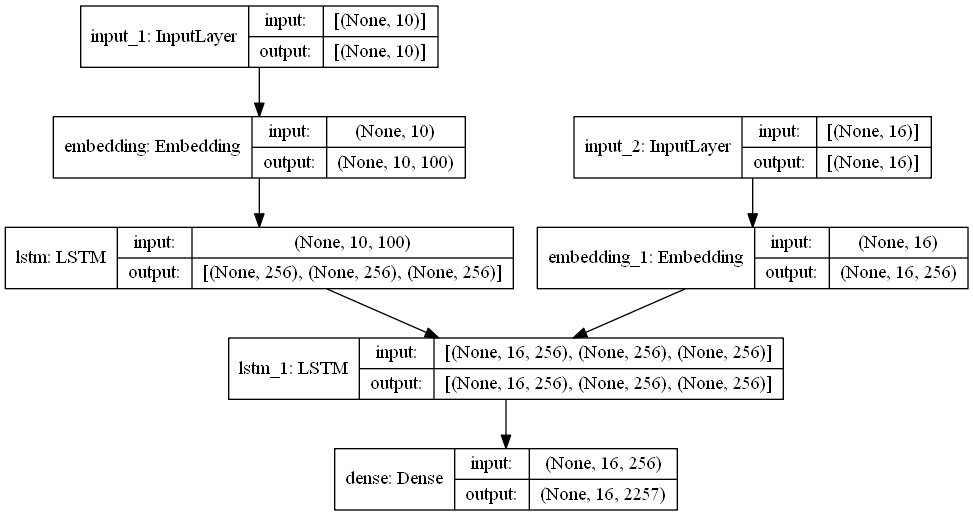

In [67]:
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

## fitting the model

In [68]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/20
31/31 [==============================] - 13s 37ms/step - loss: 3.2083 - accuracy: 0.5688 - val_loss: 3.6864 - val_accuracy: 0.4437
Epoch 2/20
31/31 [==============================] - 0s 16ms/step - loss: 2.3846 - accuracy: 0.6119 - val_loss: 3.3961 - val_accuracy: 0.4980
Epoch 3/20
31/31 [==============================] - 1s 16ms/step - loss: 2.2241 - accuracy: 0.6484 - val_loss: 3.3105 - val_accuracy: 0.5057
Epoch 4/20
31/31 [==============================] - 1s 16ms/step - loss: 2.1310 - accuracy: 0.6561 - val_loss: 3.2802 - val_accuracy: 0.5136
Epoch 5/20
31/31 [==============================] - 0s 16ms/step - loss: 2.0432 - accuracy: 0.6636 - val_loss: 3.2346 - val_accuracy: 0.5230
Epoch 6/20
31/31 [==============================] - 0s 16ms/step - loss: 1.9572 - accuracy: 0.6750 - val_loss: 3.2669 - val_accuracy: 0.5321
Epoch 7/20
31/31 [==============================] - 0s 16ms/step - loss: 1.8732 - accuracy: 0.6839 - val_loss: 3.2422 - val_accuracy: 0.5375
Epoch 8/20
3